# Детектор аномалий 2.0 на основе fprophet



## Импорты библиотек

In [1]:
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope
import pandas as pd
import plotly.express as px
from sktime.forecasting.compose import DirectTabularRegressionForecaster,DirectTimeSeriesRegressionForecaster, RecursiveTabularRegressionForecaster, TransformedTargetForecaster, ForecastingPipeline
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sktime.utils.slope_and_trend import _slope
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.date import DateTimeFeatures

from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.datasets import load_arrow_head, load_basic_motions
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender,ConditionalDeseasonalizer, Deseasonalizer
from collections import defaultdict
import itertools
from prophet import Prophet
import plotly.graph_objects as go
from scipy.stats import norm
import math
from IPython.display import clear_output
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
import pandas as pd

## Загрузка данных 1 -- IBE3

Анализируем даннные в канале ibe3

In [2]:
# Возьмём следующий диапазон для рассмотрения
date_start = '2021-01-01'
date_end = '2021-12-05'

In [3]:
# import yaml
# import base64
# cred = yaml.load(base64.b64decode(open('/home/v.baydin/.secrets/dremio-tlinc.yaml.b64','r').read()), Loader=yaml.BaseLoader)
# uid = cred['DREMIO_USER']
# pwd = cred['DREMIO_PASSWORD']
# import os
# os.environ['DREMIO_USER'] = uid
# os.environ['DREMIO_PASSWORD'] = pwd

# import pandas as pd
# from tl_datasource.dremio import get_async_dremio_connection,read_sql_to_pandas_aioodbc
# from tl_pandas_utils.sql_to_parquet import read_sql_to_pyarrow_chunked,read_sql_to_parquet


# async with get_async_dremio_connection() as conn:
#     query = f'''
#         select product_type,
#                to_char(
#                    date_trunc ('DAY' , cast(creation_date as timestamp)), 'yyyy-mm-dd'
#                    )  as product_creation_date,
#                sum(total_price) as sum_total_price,
#                sum(seg_count) as sum_seg_count,
#                count(*) as count_rows
#         from "sp_IC.TR".stat_product_ibe3
#         where creation_date > '2020-06-01'
#         group by 
#             product_type,
#             date_trunc ('DAY' , cast(creation_date as timestamp))
#     '''
#     await read_sql_to_parquet('./daily_agg_ibe3_from_june_2020_to_dec_2021_by_product.parquet', query, conn)

In [4]:
df = pd.read_parquet('daily_agg_ibe3_from_june_2020_to_dec_2021_by_product.parquet')

In [5]:
df.head()

,product_type,product_creation_date,sum_total_price,sum_seg_count,count_rows
0,seat,2021-08-06,5525761.0,31920.0,31920
1,upgrade,2021-04-21,2440730.0,348.0,348
2,aeroexpress,2021-09-16,587286.0,NaN,1095
3,pet,2021-10-07,1011885.0,332.0,272
4,insurance,2020-07-30,2042719.0,NaN,6586


#### Объяснение таблицы
Для каждого дня с июня 2020 агрегируются все уникальные (product_type, product_status, pos)

product_type --- тип услуги (breakdown = билет, остальное --- дополнительные услуги)

sum_total_price --- агрегированная сумма в рублях за всю группу
sum_seg_count --- количество пассажиросегментов
count_rows --- количесво строк оригинальной таблицы (в одной строке может быть несколько пассажиросегментов)

#### Постановка задачи

Дополнительно проагрегируем по product_type, и возьмём в качестве целевой переменной sum_seg_count.
В итоге у нас получаются временные ряды: количество пассажиросегментов а разбивке по дню/типу продукта

In [6]:
TIME_COL = 'product_creation_date'
TARGET_COL = 'sum_seg_count'
GROUP_COL = 'product_type'

# Рассмотрим только следующие продукты
# used_groups = ['breakdown','seat', 'bag', 'sms','upgrade','meal','pet','prepay']

df_filtered = df[
    (df[TIME_COL] > date_start)
    & (df[TIME_COL] < date_end)
    # & (df[GROUP_COL].isin(used_groups))
]

df_pc1 = pd.DataFrame(
    df_filtered.groupby([TIME_COL, GROUP_COL])[TARGET_COL].agg(sum)
).reset_index().rename(columns={TARGET_COL: 'total'})

dum = pd.get_dummies(df_pc1[[GROUP_COL]], columns=[GROUP_COL]
                    ).multiply(df_pc1['total'], axis='index')
columns = list(dum.columns)
d = pd.concat([df_pc1[[TIME_COL, 'total']], dum], axis='columns')
df_pc1 = d.groupby(TIME_COL)[columns].agg(sum)

columns = [s.replace(GROUP_COL,'ibe3') for s in columns]
df_pc1.columns = columns

df_pc1.head()

,ibe3_aeroexpress,ibe3_auto_checkin,ibe3_bag,ibe3_breakdown,ibe3_car,ibe3_extra_seat,ibe3_fast_track,ibe3_flight_change,ibe3_foodbox,ibe3_free_refund,...,ibe3_insurance,ibe3_lounge,ibe3_meal,ibe3_pet,ibe3_prepay,ibe3_seat,ibe3_sms,ibe3_subscription,ibe3_transfer,ibe3_upgrade
product_creation_date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,0.0,0.0,2865.0,45010.0,0.0,0.0,0.0,2.0,17.0,0.0,...,0.0,69.0,752.0,288.0,101.0,25929.0,1800.0,0.0,0.0,404.0
2021-01-03,0.0,0.0,3025.0,40145.0,0.0,0.0,0.0,0.0,12.0,0.0,...,0.0,48.0,778.0,268.0,106.0,22752.0,1858.0,0.0,0.0,343.0
2021-01-04,0.0,0.0,2963.0,39473.0,0.0,0.0,0.0,1.0,14.0,0.0,...,0.0,32.0,648.0,321.0,76.0,20355.0,1667.0,0.0,0.0,383.0
2021-01-05,0.0,0.0,2979.0,39214.0,0.0,0.0,0.0,3.0,15.0,0.0,...,0.0,38.0,672.0,324.0,102.0,20441.0,1689.0,0.0,0.0,321.0
2021-01-06,0.0,0.0,2938.0,34951.0,0.0,0.0,0.0,1.0,9.0,0.0,...,0.0,40.0,633.0,275.0,130.0,17423.0,1386.0,0.0,0.0,310.0


## Загрузка данных 2: Stat_ancillaries_total

In [ ]:
# async with get_async_dremio_connection() as conn:
#     query = f'''
#         select product_type,
#                to_char(
#                    date_trunc ('DAY' , cast(creation_date as timestamp)), 'yyyy-mm-dd'
#                    )  as product_creation_date,
#                sum(price) as sum_total_price,
#                count(*) as count_rows
#         from "sp_IC.TR".stat_ancillaries_total
#         where creation_date > '2020-06-01'
#         group by 
#             product_type,
#             date_trunc ('DAY' , cast(creation_date as timestamp))
#     '''
#     await read_sql_to_parquet('./daily_agg_stat_ancillaries_total_from_june_2020_to_dec_2021_by_product.parquet', query, conn)


In [7]:
df = pd.read_parquet('daily_agg_stat_ancillaries_total_from_june_2020_to_dec_2021_by_product.parquet')

In [8]:
df.head()

,product_type,product_creation_date,sum_total_price,count_rows
0,hotel,2020-11-12,7823526.43,537
1,lounge,2020-12-17,116450.00,62
2,transfer,2020-11-22,30984.95,14
3,prepay,2020-12-18,154250.00,471
4,insurance,2020-12-21,1434306.00,4504


In [9]:
TIME_COL = 'product_creation_date'
TARGET_COL = 'count_rows'
GROUP_COL = 'product_type'

# # Рассмотрим только следующие продукты
# used_groups = ['aeroexpress',
#                  'auto_checkin',
#                  'bag',
#                  'car',
#                  'foodbox',
#                  'hotel',
#                  'insurance',
#                  'lounge',
#                  'meal',
#                  'pet',
#                  'prepay',
#                  'seat',
#                  'sms',
#                  'transfer',
#                  'upgrade']

df_filtered = df[
    (df[TIME_COL] > date_start)
    & (df[TIME_COL] < date_end)
    # & (df[GROUP_COL].isin(used_groups))
]

df_pc2 = pd.DataFrame(
    df_filtered.groupby([TIME_COL, GROUP_COL])[TARGET_COL].agg(sum)
).reset_index().rename(columns={TARGET_COL: 'total'})

dum = pd.get_dummies(df_pc2[[GROUP_COL]], columns=[GROUP_COL]
                    ).multiply(df_pc2['total'], axis='index')
columns = list(dum.columns)
d = pd.concat([df_pc2[[TIME_COL, 'total']], dum], axis='columns')
df_pc2 = d.groupby(TIME_COL)[columns].agg(sum)

columns = [s.replace(GROUP_COL,'stat_total') for s in columns]
df_pc2.columns = columns



df_pc2.head()

,stat_total_aeroexpress,stat_total_auto_checkin,stat_total_bag,stat_total_car,stat_total_excursion,stat_total_extra_seat,stat_total_fast_track,stat_total_flight_change,stat_total_foodbox,stat_total_free_refund,...,stat_total_insurance,stat_total_lounge,stat_total_meal,stat_total_pet,stat_total_prepay,stat_total_seat,stat_total_sms,stat_total_subscription,stat_total_transfer,stat_total_upgrade
product_creation_date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,260,0,2245,5,2,0,0,2,17,0,...,5547,67,638,122,57,12691,1520,0,40,209
2021-01-03,236,0,2194,2,6,0,0,0,12,0,...,5108,48,581,119,64,11340,1597,0,32,203
2021-01-04,248,0,2296,7,4,0,0,1,14,0,...,4683,29,514,147,47,11132,1467,0,33,221
2021-01-05,223,0,2237,9,1,0,0,3,15,0,...,4583,37,583,136,66,11454,1551,0,27,201
2021-01-06,247,0,2027,4,5,0,0,1,9,0,...,4187,37,536,107,72,10217,1273,0,19,190


# Объединяем ряды в один датасет

In [10]:
df_pc = pd.concat([df_pc1,df_pc2], axis=1)
df_pc.index = pd.to_datetime(df_pc.index)

In [11]:
# Checking absence of zero columns(required by the model)
nonzero = (df_pc == 0).any(axis=0)
nz = list(nonzero[~nonzero].index)

In [12]:
df_pc = df_pc[nz]

In [13]:
df_pc.head()

,ibe3_bag,ibe3_breakdown,ibe3_foodbox,ibe3_lounge,ibe3_meal,ibe3_pet,ibe3_prepay,ibe3_seat,ibe3_sms,ibe3_upgrade,...,stat_total_hotel,stat_total_insurance,stat_total_lounge,stat_total_meal,stat_total_pet,stat_total_prepay,stat_total_seat,stat_total_sms,stat_total_transfer,stat_total_upgrade
product_creation_date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,2865.0,45010.0,17.0,69.0,752.0,288.0,101.0,25929.0,1800.0,404.0,...,282,5547,67,638,122,57,12691,1520,40,209
2021-01-03,3025.0,40145.0,12.0,48.0,778.0,268.0,106.0,22752.0,1858.0,343.0,...,253,5108,48,581,119,64,11340,1597,32,203
2021-01-04,2963.0,39473.0,14.0,32.0,648.0,321.0,76.0,20355.0,1667.0,383.0,...,296,4683,29,514,147,47,11132,1467,33,221
2021-01-05,2979.0,39214.0,15.0,38.0,672.0,324.0,102.0,20441.0,1689.0,321.0,...,265,4583,37,583,136,66,11454,1551,27,201
2021-01-06,2938.0,34951.0,9.0,40.0,633.0,275.0,130.0,17423.0,1386.0,310.0,...,253,4187,37,536,107,72,10217,1273,19,190


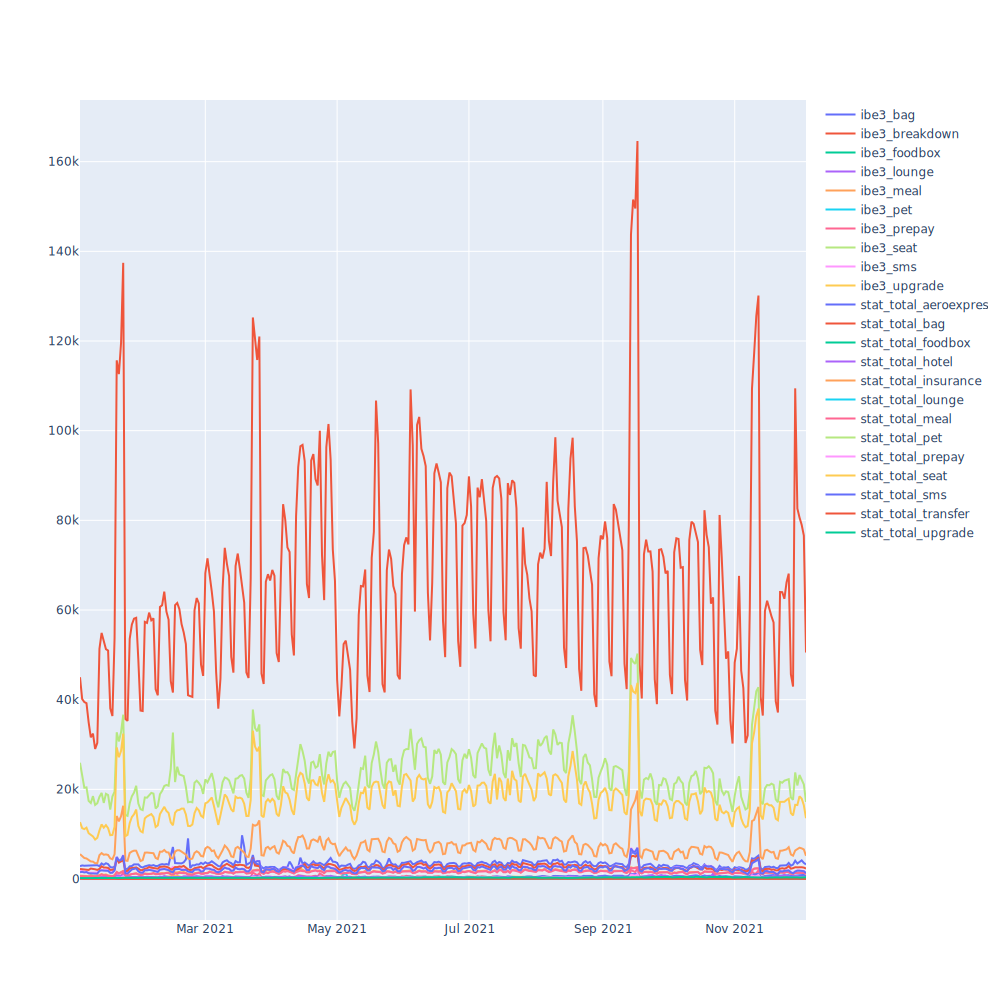

In [14]:
figure = go.Figure(layout=dict(width=1000, height=1000))
for col in df_pc.columns:
    figure.add_trace(go.Scatter(x=df_pc.index, y=df_pc[col], name=col))
figure.show(renderer='svg')

In [15]:
# Добавляем распродажи

sales = pd.DataFrame({
  'holiday': 'sale',
  'ds': pd.to_datetime(
      ['2020-06-23','2020-09-15', '2020-11-10', '2020-12-15','2021-01-19', '2021-03-23', '2021-09-14','2021-11-09']
  ),
  'lower_window': 0,
  'upper_window': 4,
})
import datetime
sale_dates=[]
for _, row in sales.iterrows():
    for shift in range(row.lower_window, row.upper_window+1):
        sale_dates.append(row.ds+datetime.timedelta(days=shift))

Было замечено, что Prophet некорректно работает с мультипликативной сезонностью. В нашем случае как раз хочется сделать все добавки мультипликативными. 

Поэтому применяем хак: логарифмируем все ряды (если где-то есть 0, то не сработает) и используем аддитивную сезонность

Исключаем годовую сезонность, потому что у нас меньше года и смысла в этом нет

В качестве регрессора добавляем переменную breakdown (везде кроме предсказания тотала и breakdown)

In [16]:
predictions = {}
for col in df_pc.columns:
    print(col)
        
    log1past = pd.DataFrame(df_pc[col]).reset_index().rename(columns={col:'y',TIME_COL:'ds'})
    log1past['y'] = np.log(log1past.y)
    m = Prophet(
        holidays=sales,
        weekly_seasonality = True,
        daily_seasonality = False,
        yearly_seasonality = False,
        n_changepoints = 6,
        interval_width=0.99,
    #     mcmc_samples = 300,
        seasonality_mode='additive',
    )
    if col not in ('ibe3_breakdown',):
        log1past['ibe3_breakdown'] = np.log(df_pc['ibe3_breakdown'].values)
        m.add_regressor('ibe3_breakdown')
    m.fit(log1past)
    forecast = m.predict(log1past)
    yhat = np.exp(forecast['yhat'].values)
    y = df_pc[col]
    sigma = np.std(y-yhat)
#     Сохраняем по каждому продукту предсказания, а также считаем стандартное отклонение факта от предсказания
    predictions[col] = pd.DataFrame(
        index=df_pc.index,
        data={
        'yhat': yhat,
        'y': y,
        'sigma':sigma          
        }
       )
clear_output()

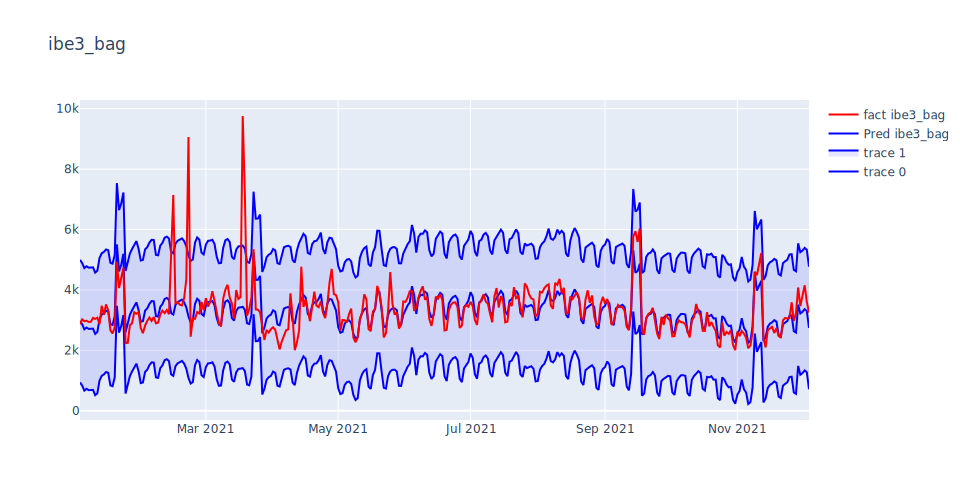

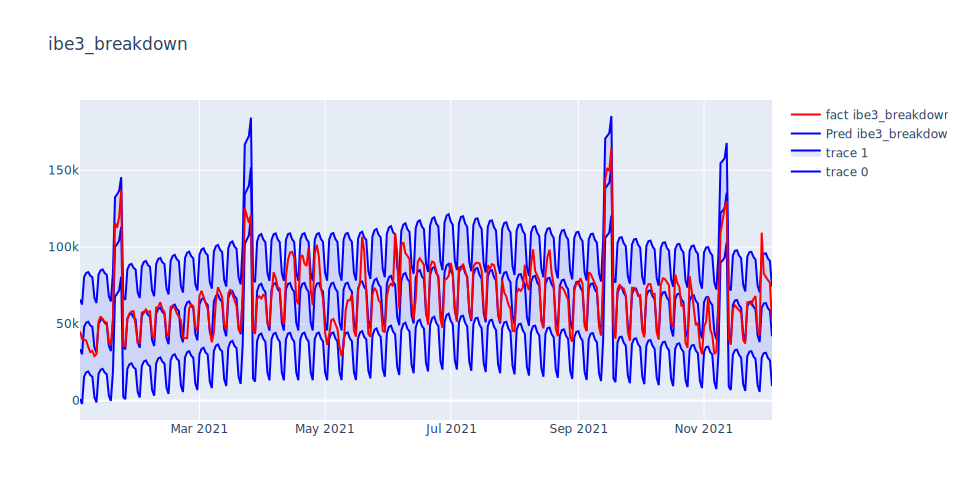

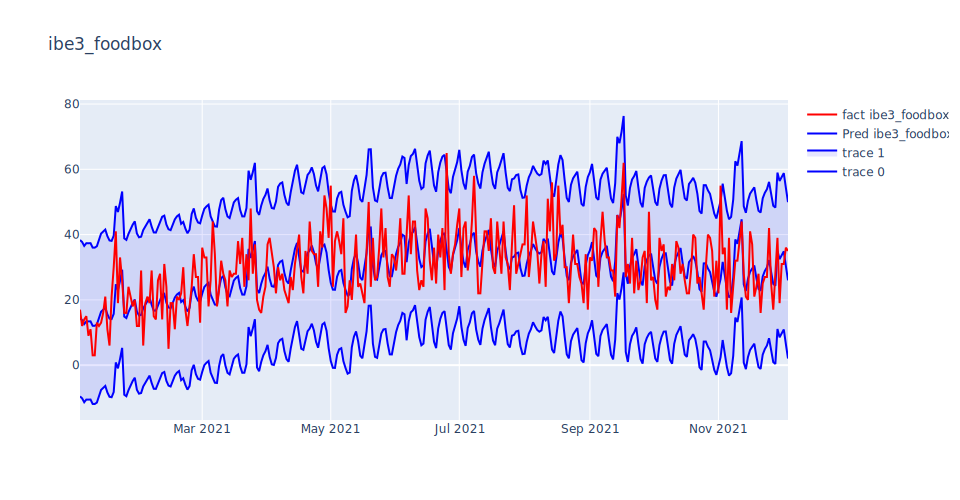

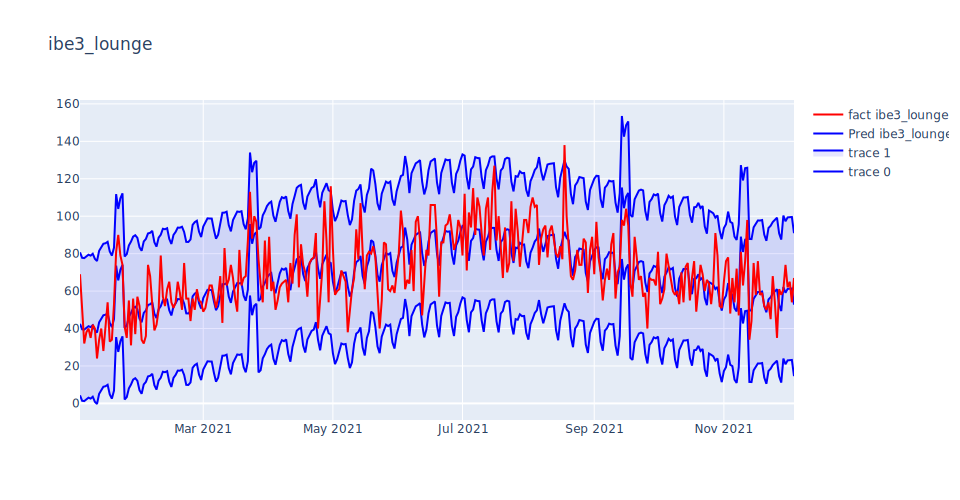

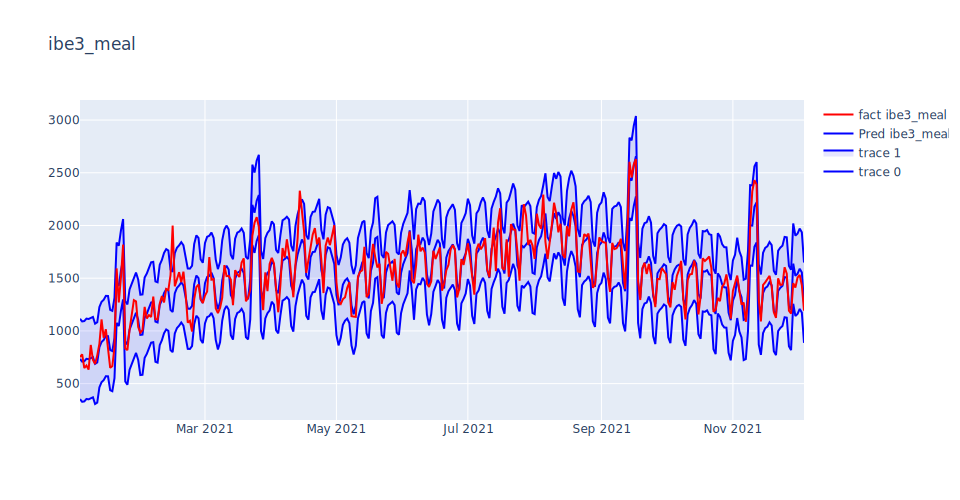

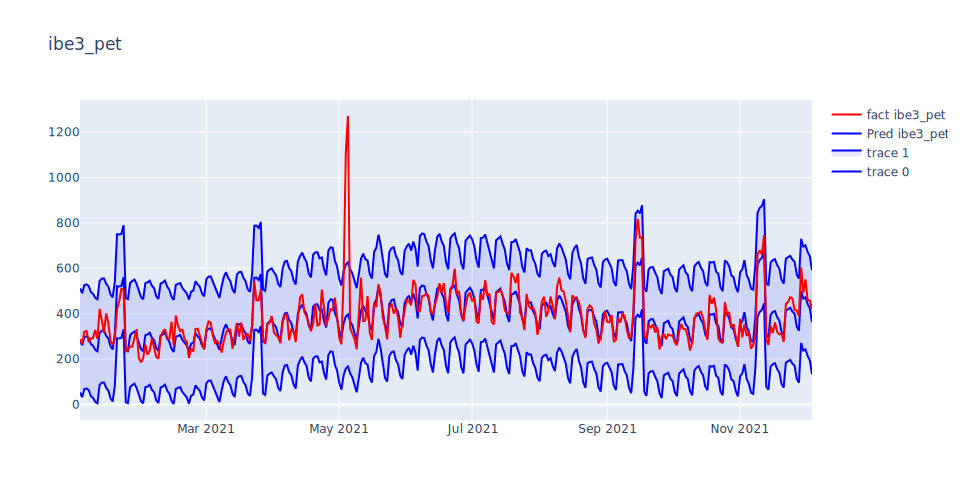

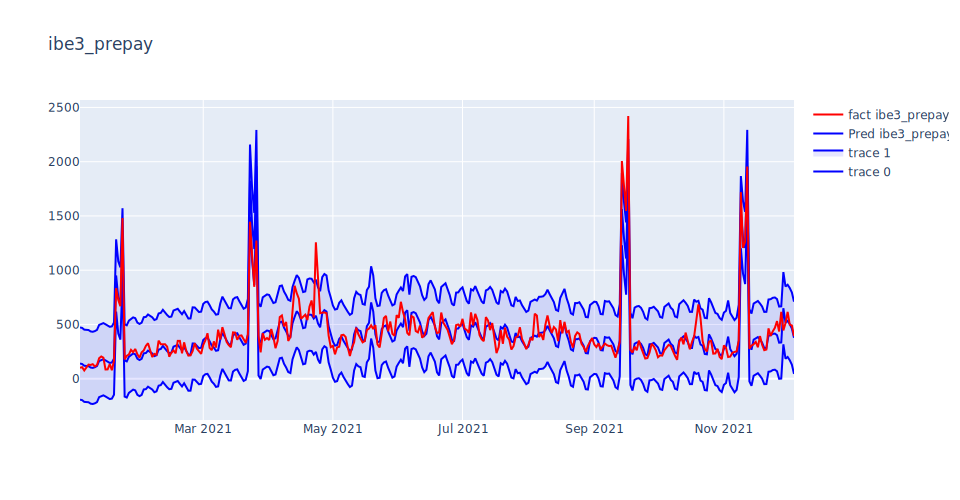

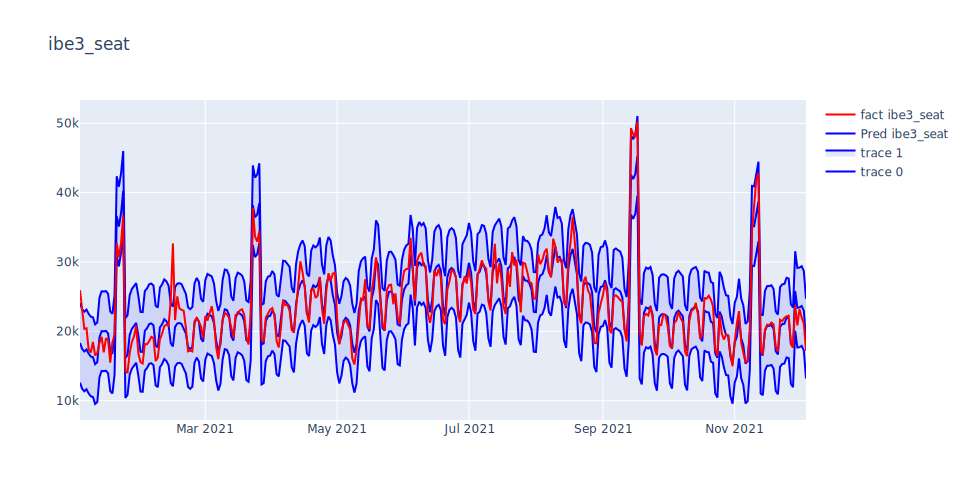

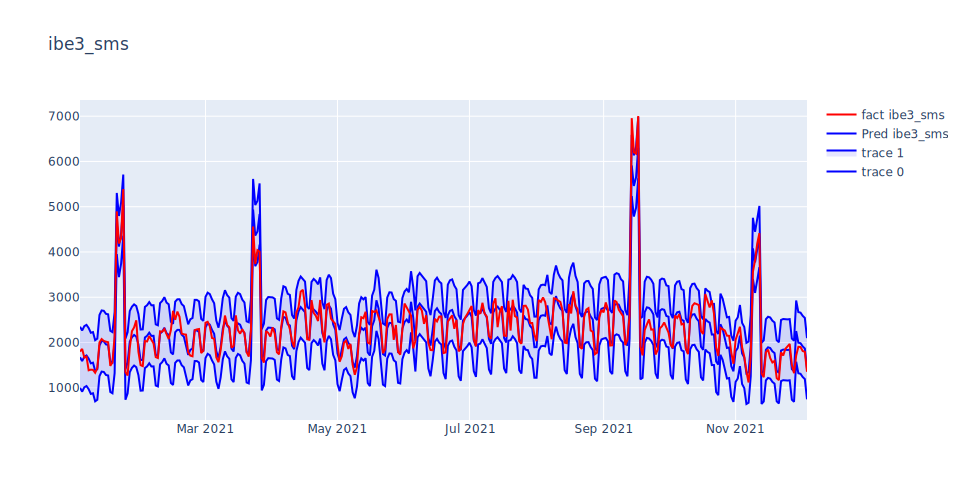

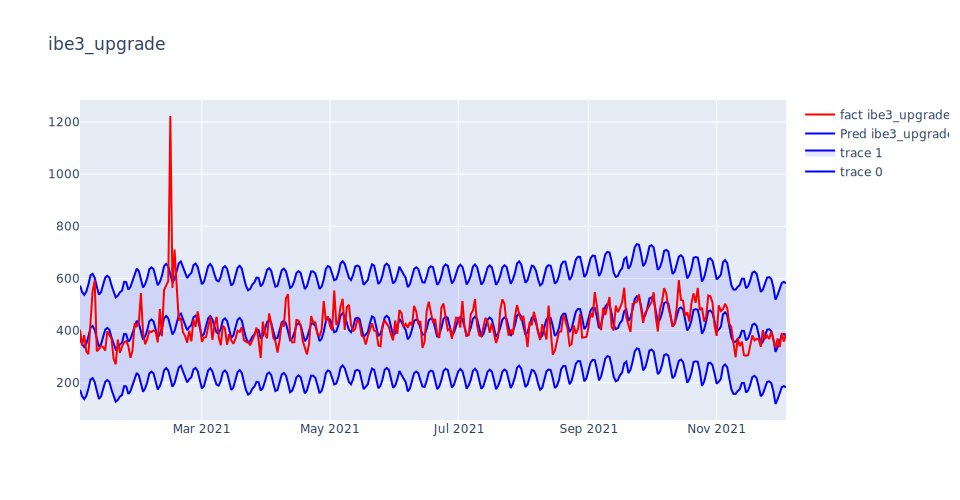

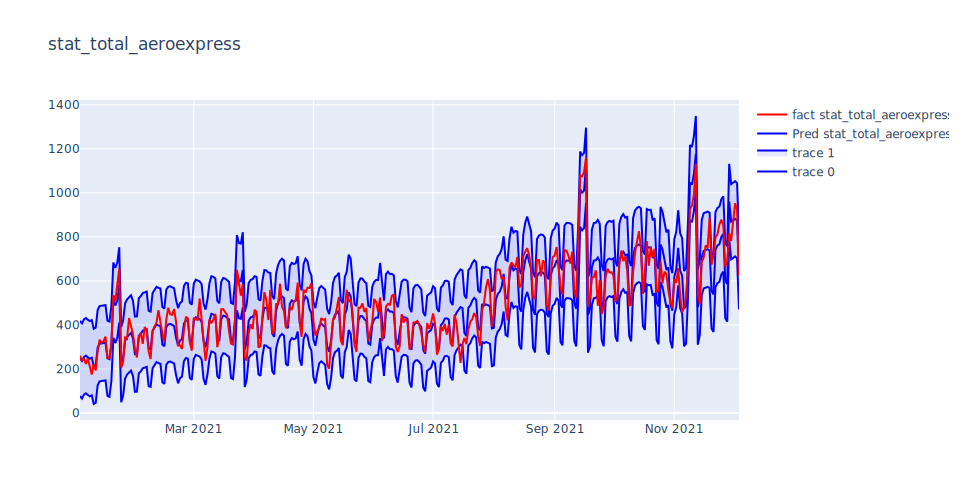

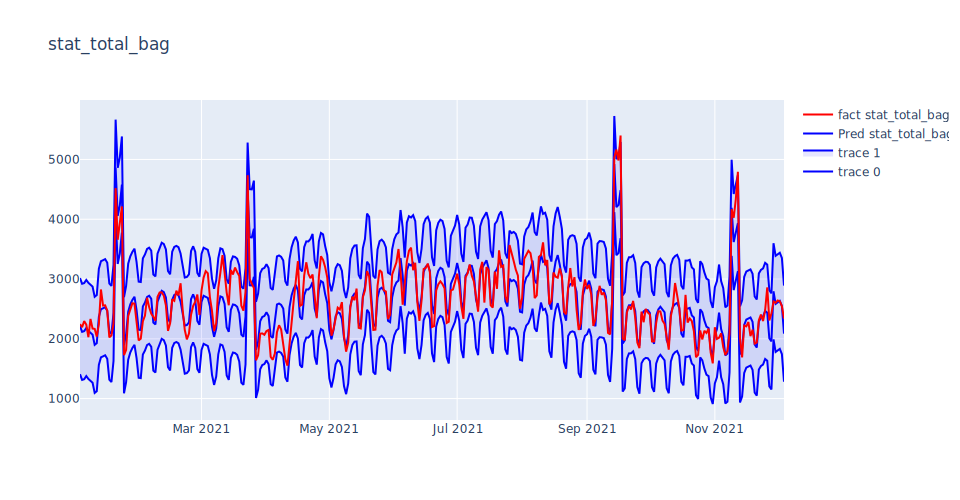

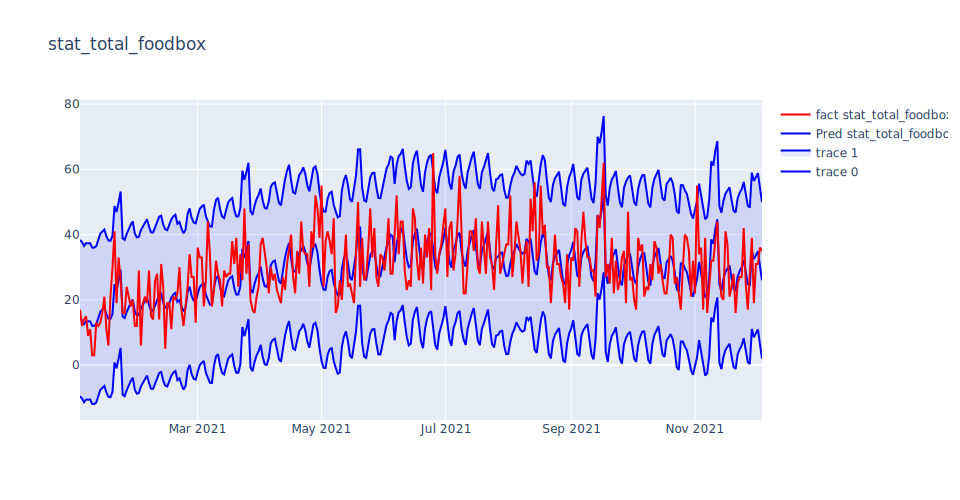

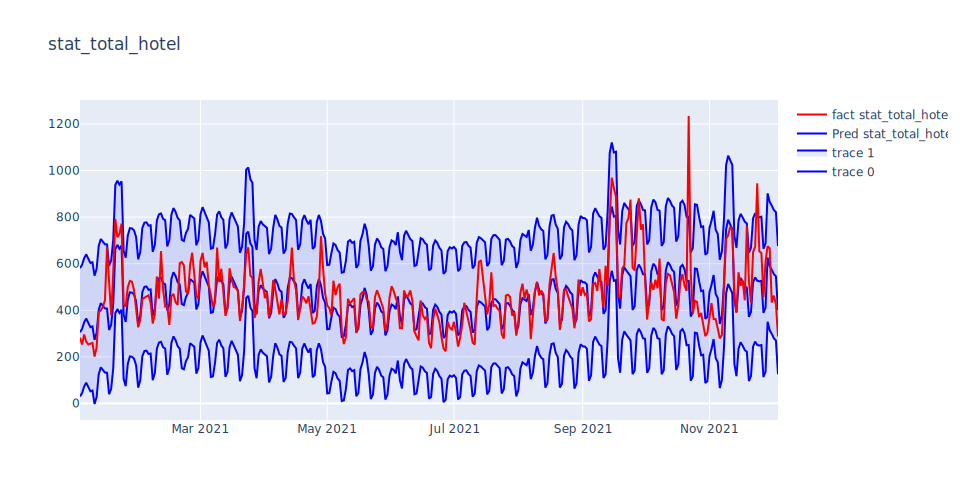

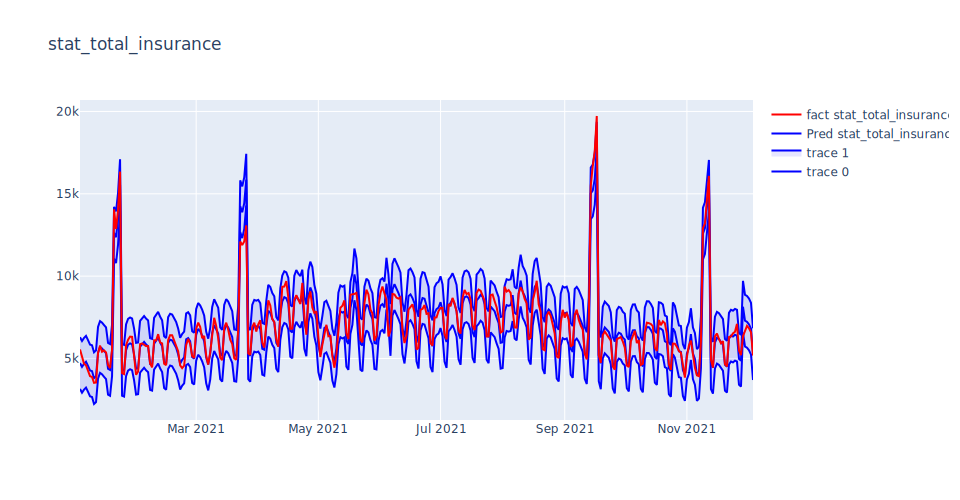

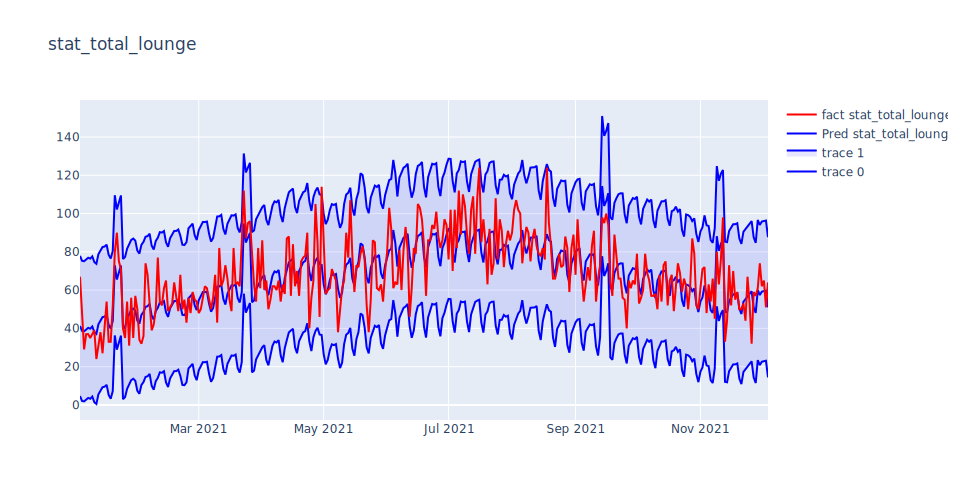

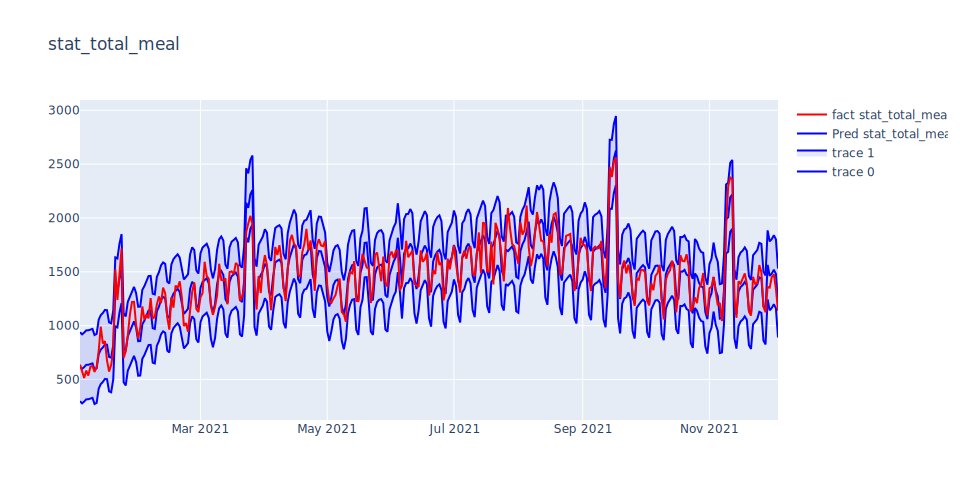

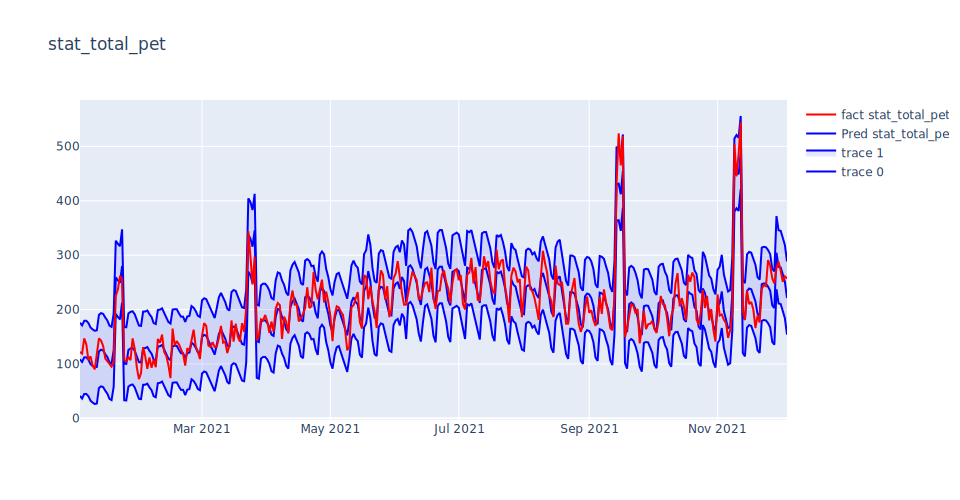

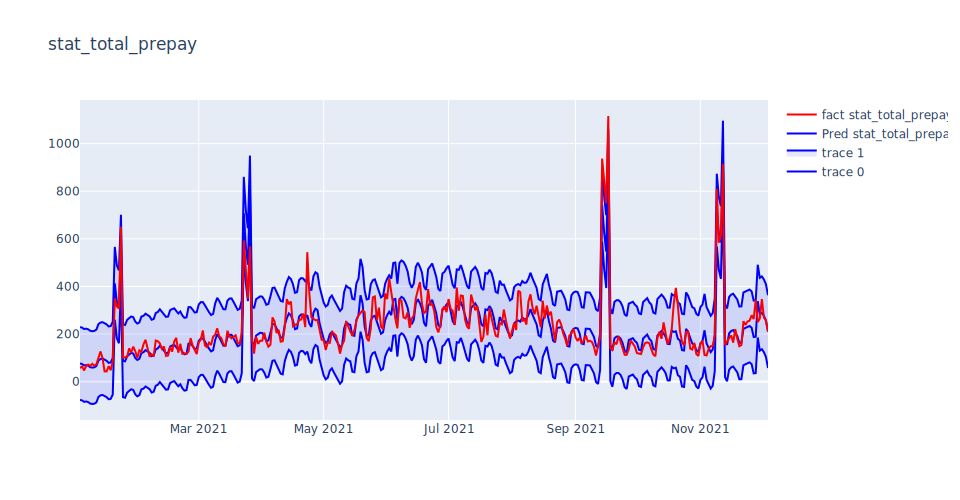

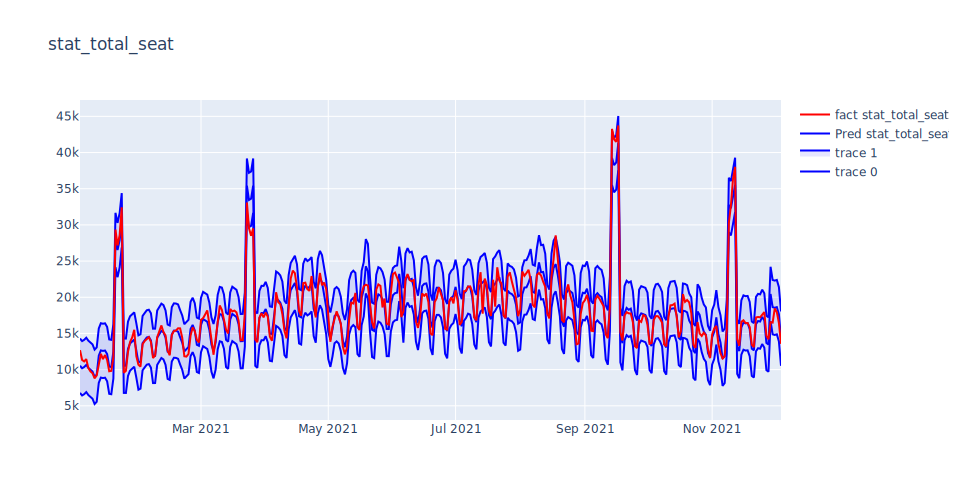

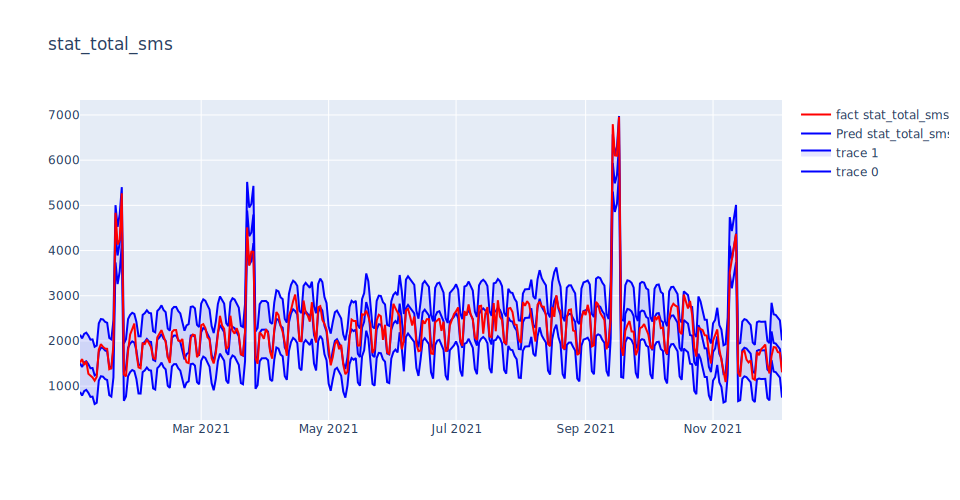

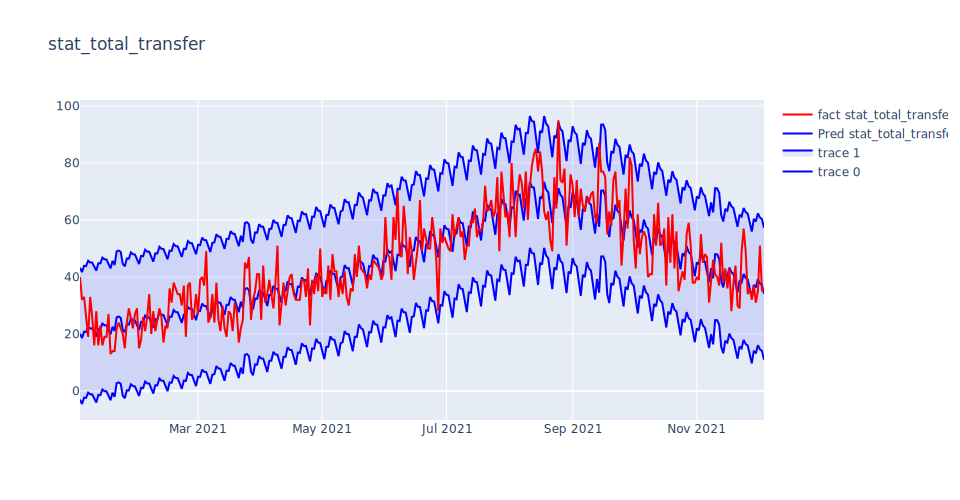

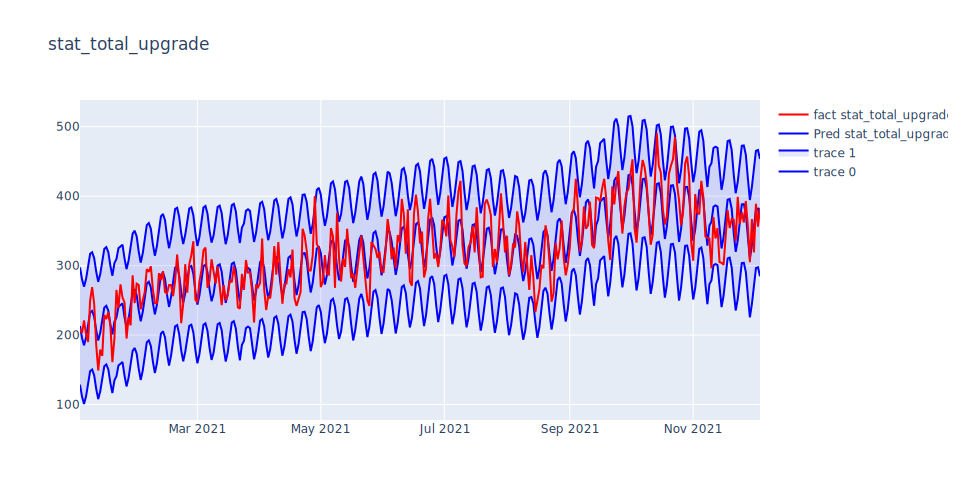

In [17]:
for col in df_pc.columns:
    figure = go.Figure(layout={'title':col, 'width':960})
    pred = predictions[col]
    yhat_lower = pred.yhat - 3*pred.sigma
    yhat_upper = pred.yhat + 3*pred.sigma
    
    
    figure.add_trace(go.Scatter(x=pred.index, y=yhat_upper,
    fill=None, mode='lines', line_color='blue', fillcolor='rgba(0,0,255,0.4)'))
    
    figure.add_trace(go.Scatter(x=pred.index, y=yhat_lower,
    fill='tonexty', mode='lines', line_color='blue', fillcolor='rgba(0,0,255,0.1)'))
    
    figure.add_trace(go.Scatter(x=pred.index, y=pred['yhat'], name=f'Pred {col}', line_color='blue'))
    figure.add_trace(go.Scatter(x=df_pc.index, y=pred['y'], name=f'fact {col}', line_color='red'))
    figure.show(renderer='svg')

## Детекция аномалий

Для детекции аномалий оценим правдоподобие получившихся значений факта, при справедливости нулевой гипотезы о том, что временной ряд распределён по Гауссу с мат. ожиданием yhat и стандартным отклонением sigma, предсказанной Prophet

Правдоподобие будем оценивать не только по одиночной величине, но и с помощью скользящего окна
Для каждого значения размера окна $w_s$ мы усредним последние $w_s$ значений отклонения факта от предсказания. 

Поскольку мы считаем, что единичное отконение распределено нормально с нулевым матожиданием и стд=$\sigma$, то скользящее среднее тоже будет нормальным с стд $\frac{\sigma}{\sqrt{w_s}}$

Для порога аномалии выберем 99% квантиль, то есть 3*стд

Чтобы было нагляднее, нормируем данные, чтобы нулевая разница факта и предсказания имела скор 0, а пороговая --- 1



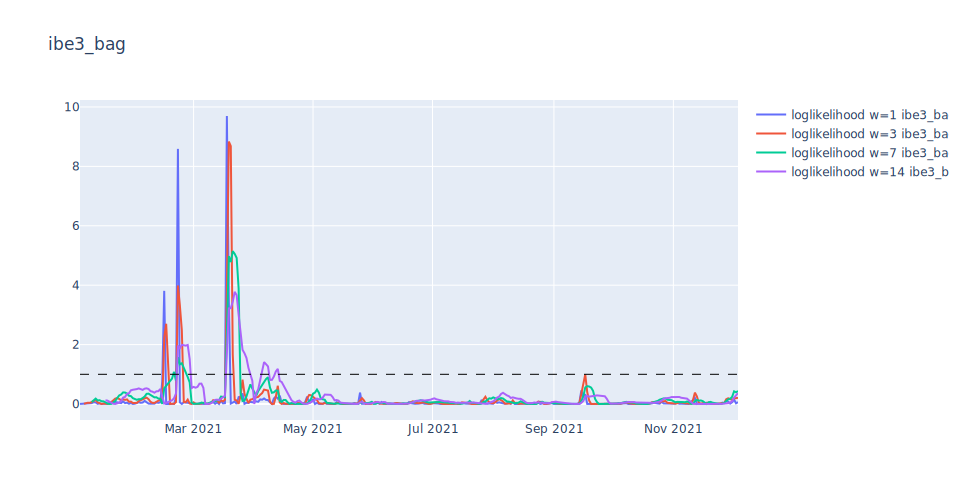

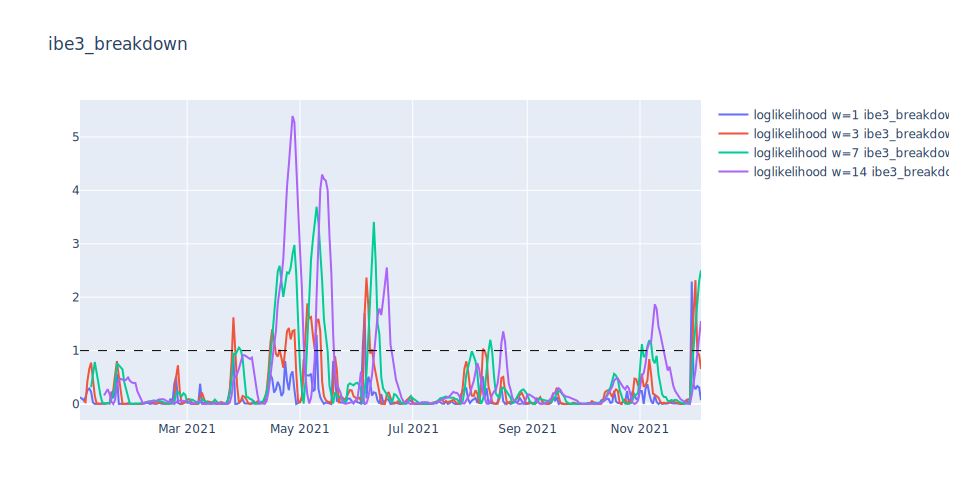

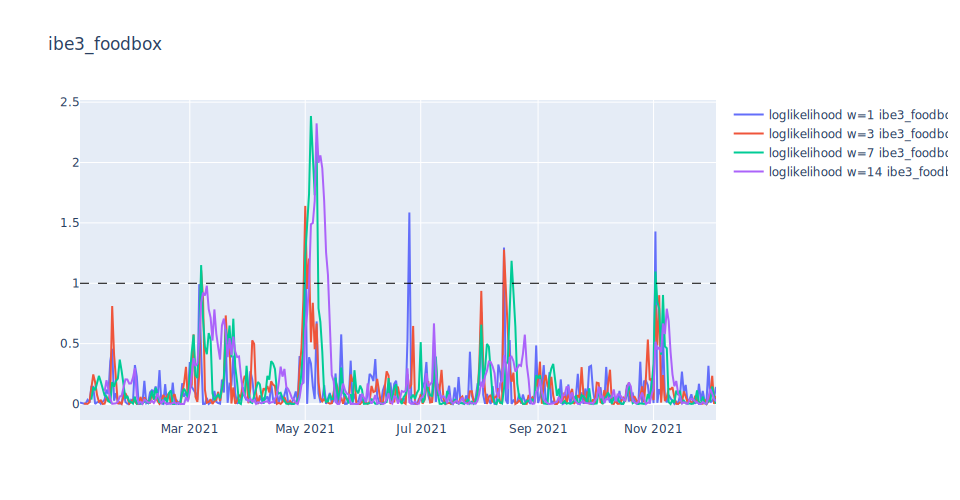

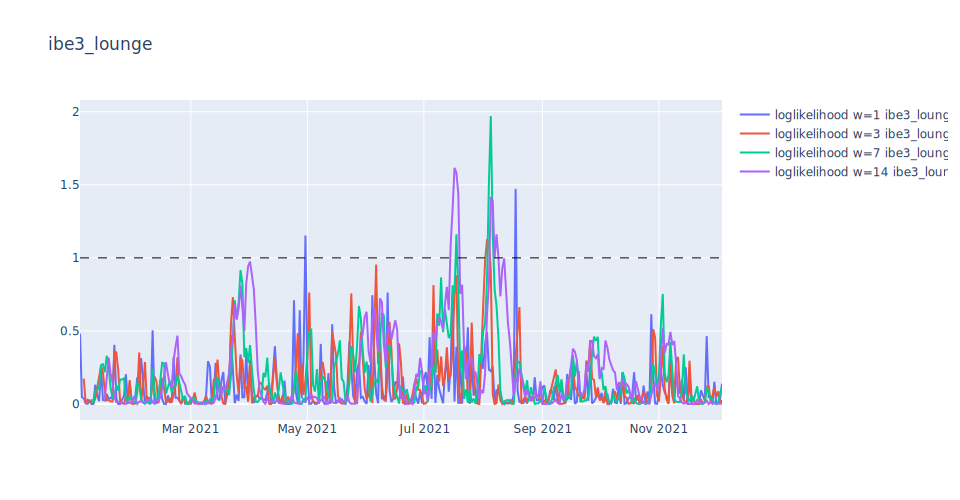

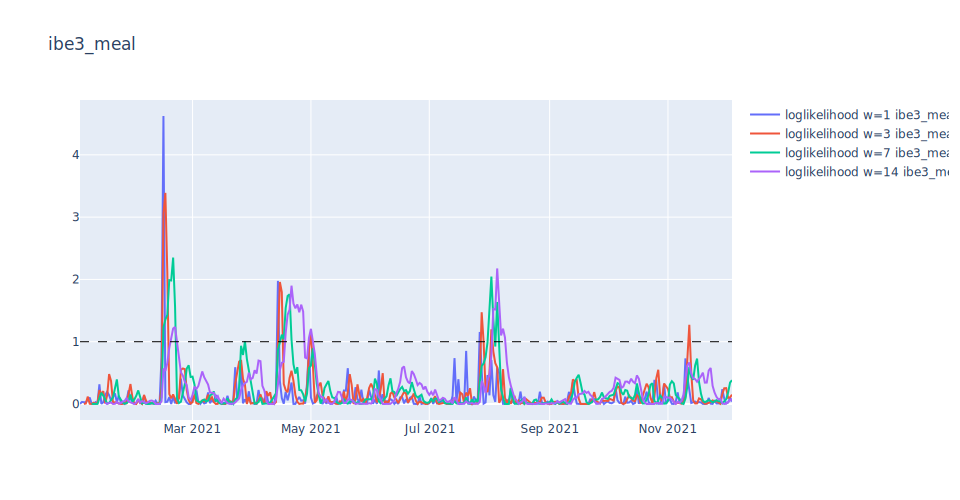

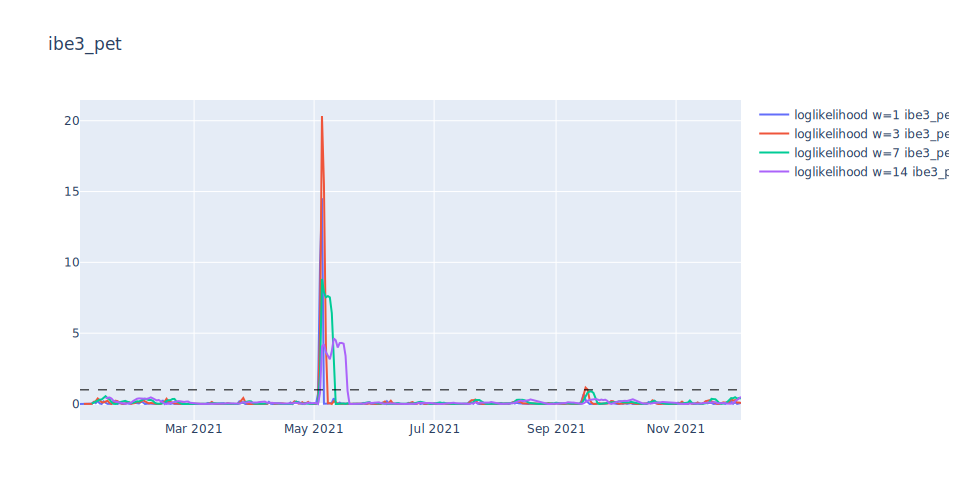

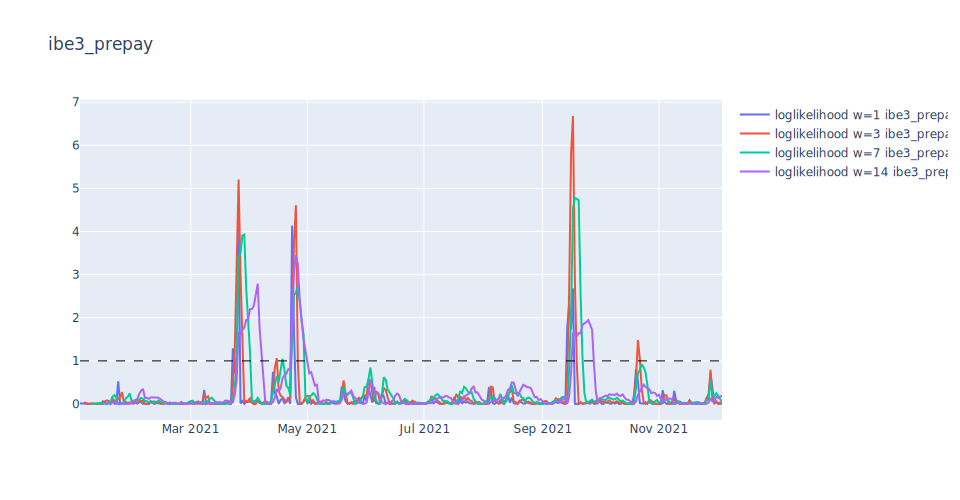

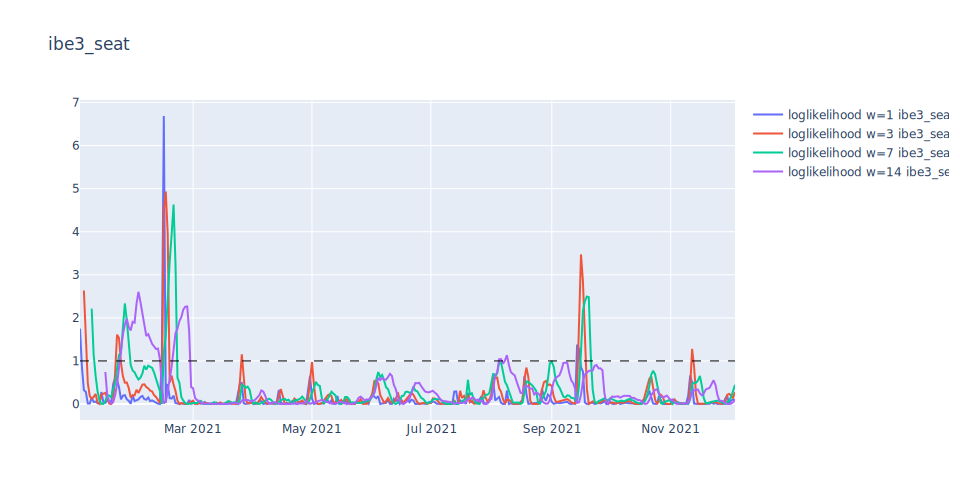

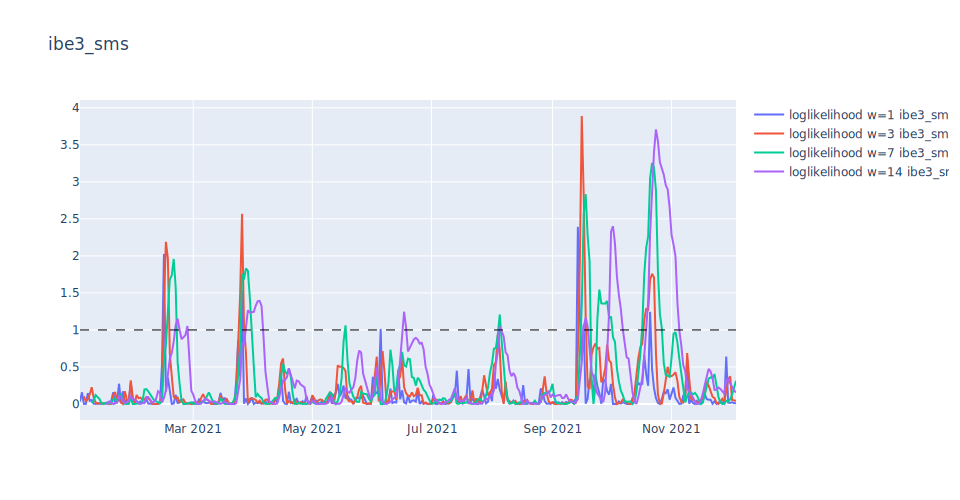

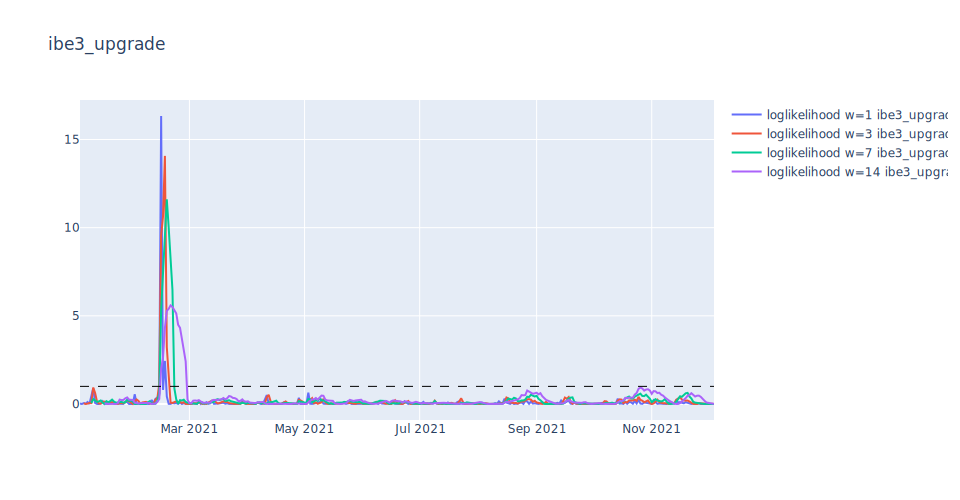

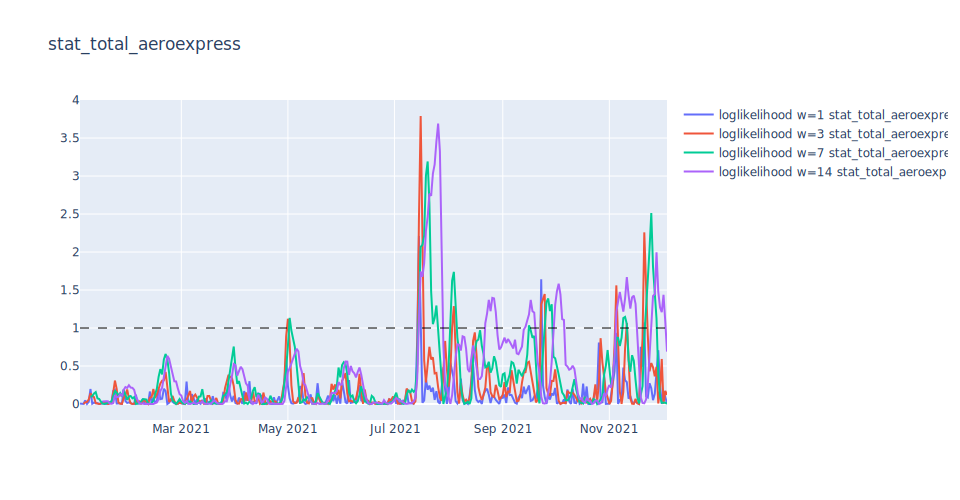

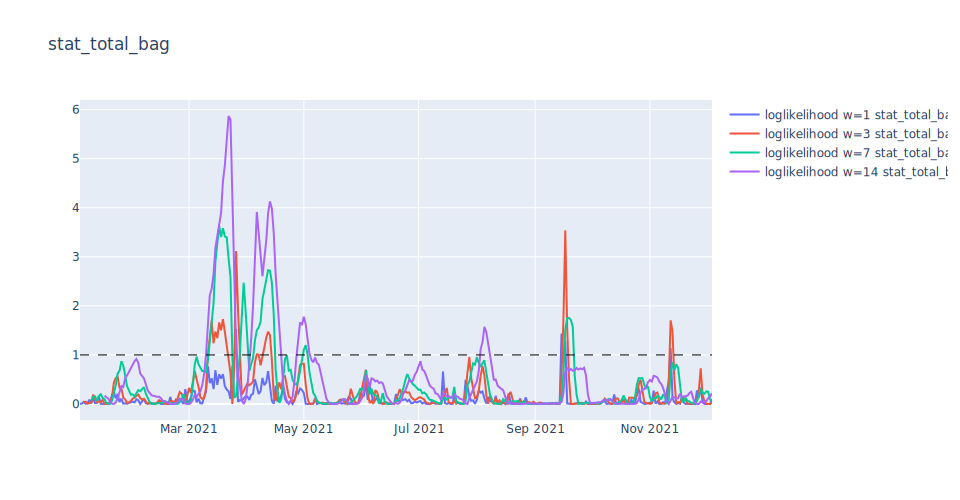

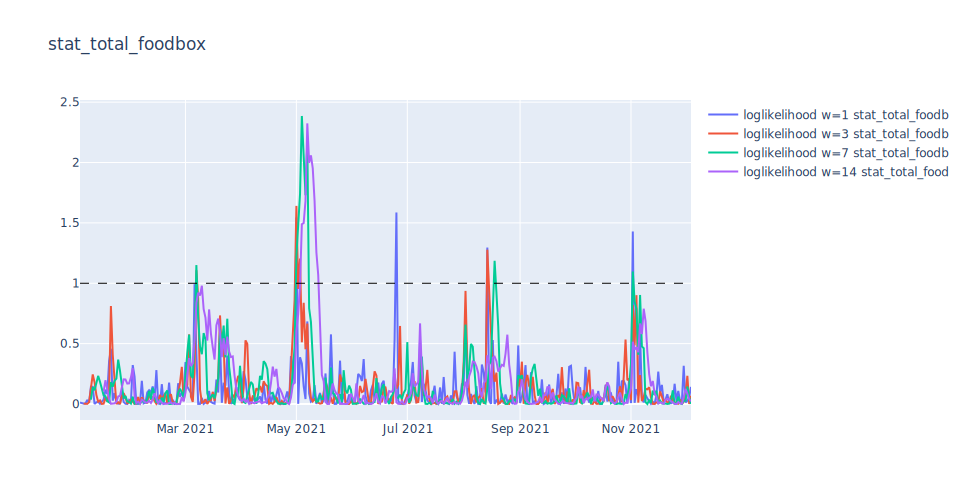

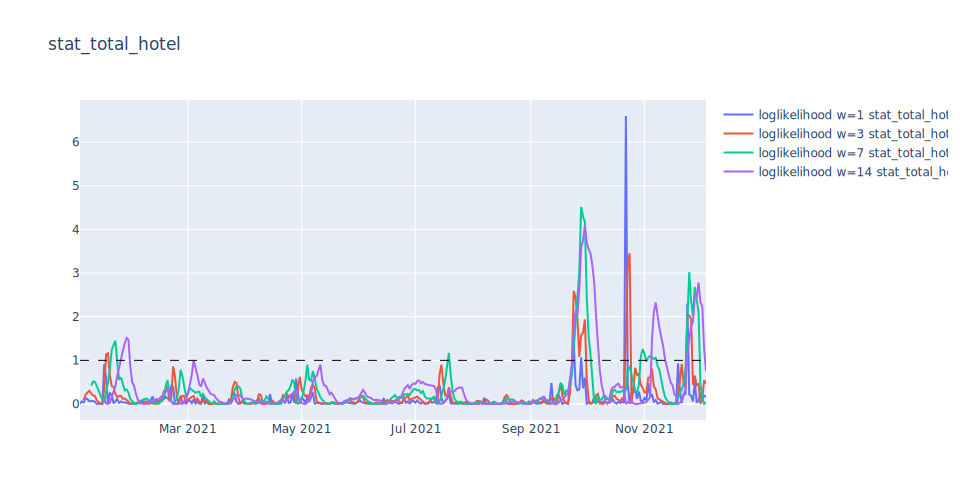

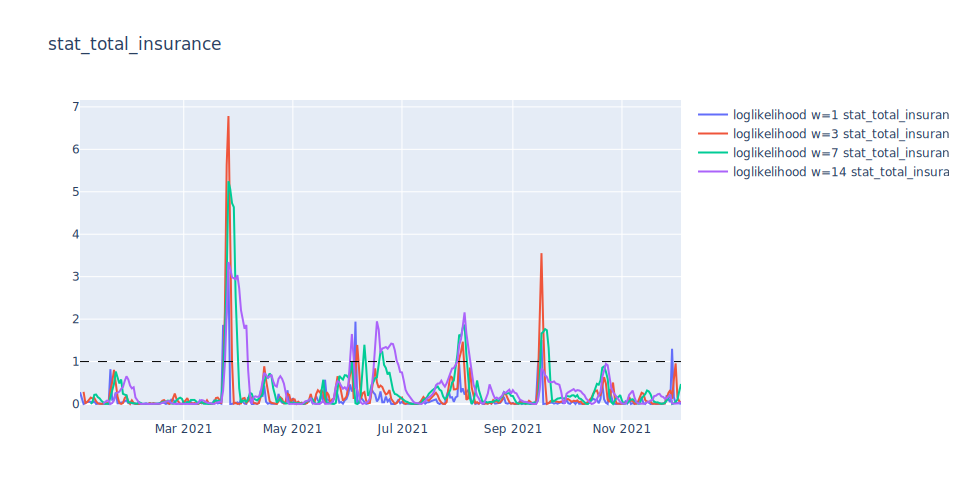

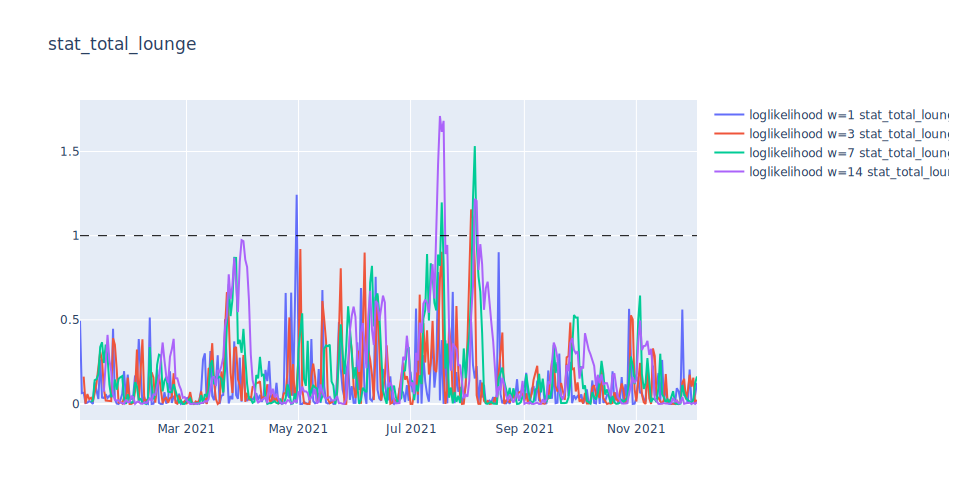

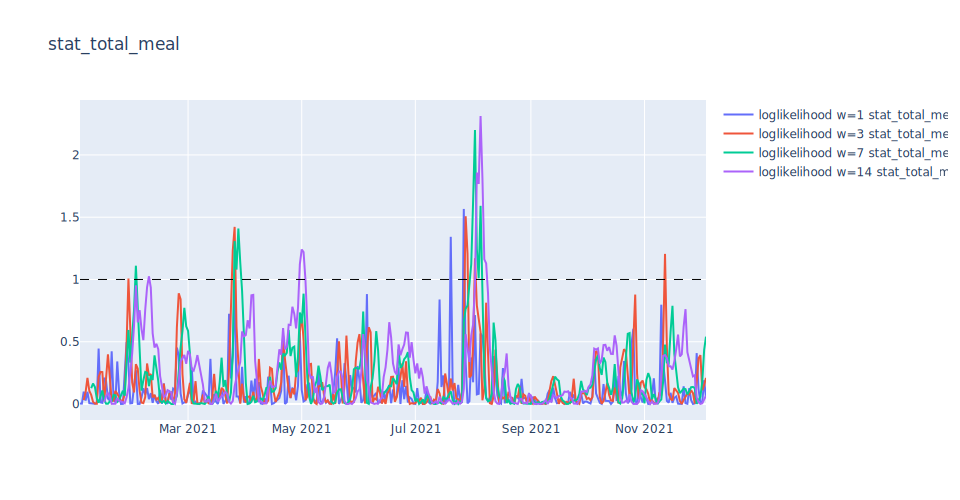

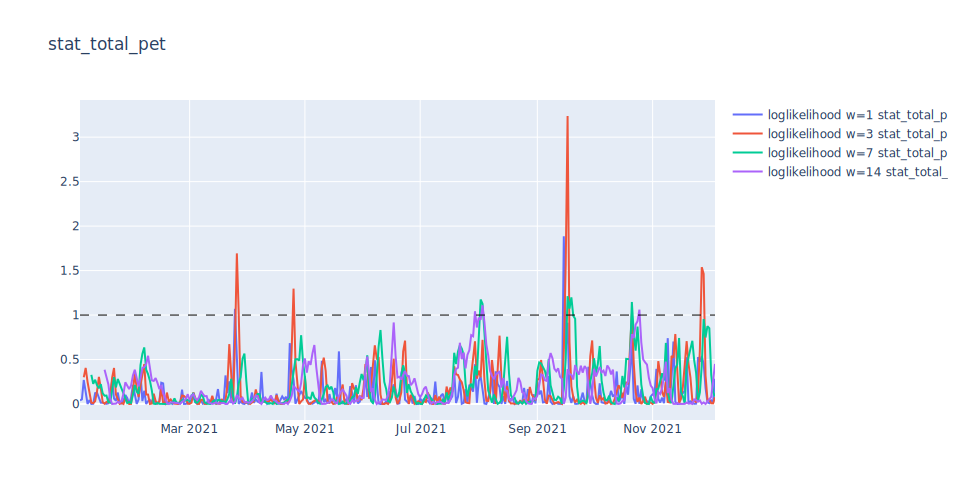

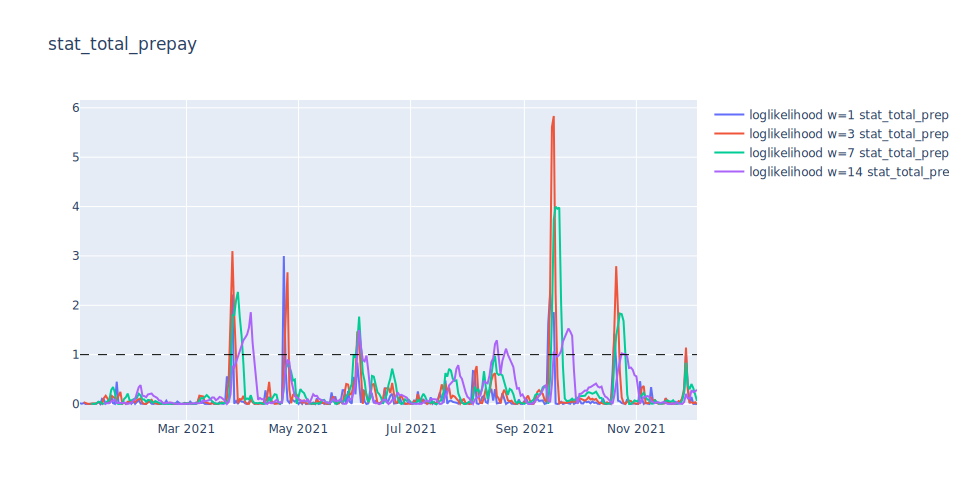

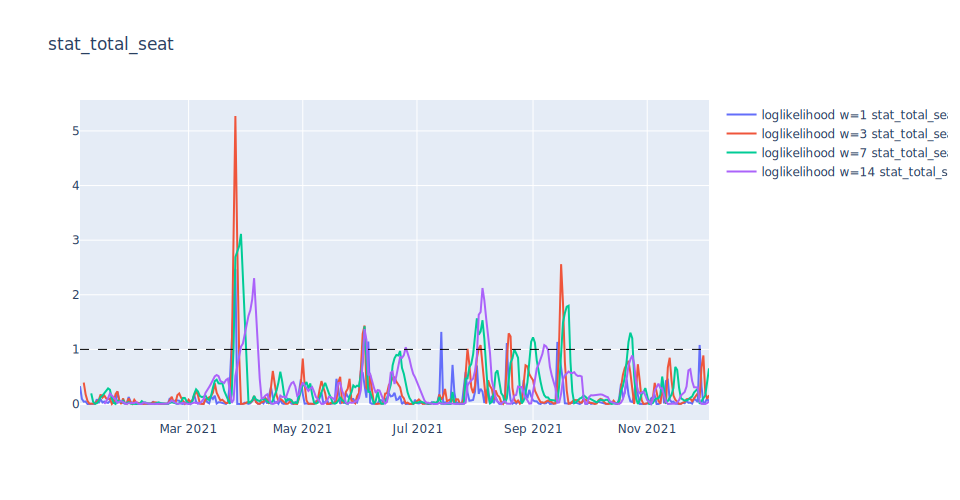

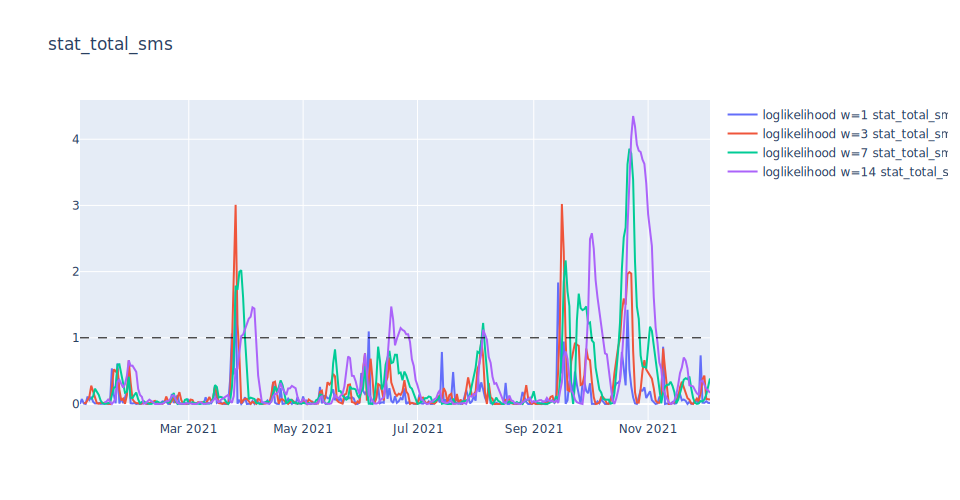

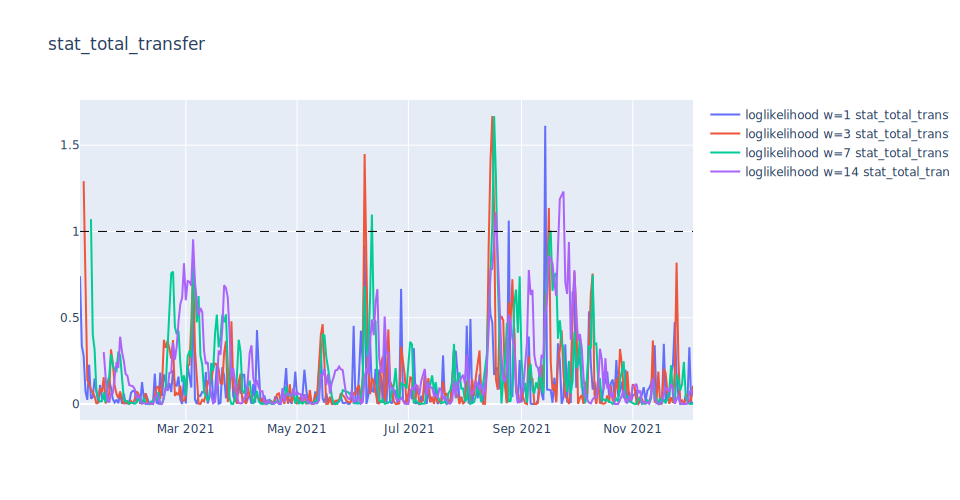

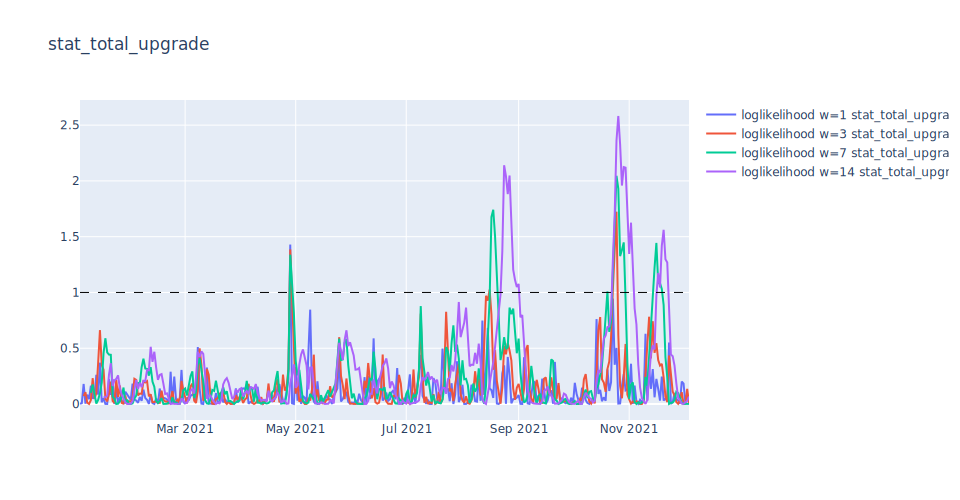

In [18]:
anomalies = {}
for col in df_pc.columns:
    pred = predictions[col]

    figure = go.Figure(layout={'title': col, 'width': 960})
    anomalies[col] = {}
    for ws in (1, 3, 7, 14):
        anomalies[col][ws] = pd.DataFrame(index=df_pc.index)
        
        delta = (pred.y-pred.yhat).rolling(ws, win_type='boxcar').mean()
        anomalies[col][ws]['delta'] = delta
        
        sigma = pred.sigma/math.sqrt(ws)
        anomalies[col][ws]['sigma'] = sigma

        zero_level = -np.log(norm.pdf(0, loc=0, scale=sigma))
        anomaly_threshold = -np.log(norm.pdf(3*sigma, loc=0, scale=sigma))

        loglikelihood = -np.log(norm.pdf(delta, loc=0, scale=sigma))
        ll_normalized = ((loglikelihood-zero_level) /
                         (anomaly_threshold - zero_level))
        
        anomalies[col][ws]['magnitude'] = ll_normalized
        anomalies[col][ws]= anomalies[col][ws].fillna(0)
        
        figure.add_trace(go.Scatter(
            x=df_pc.index, y=ll_normalized, name=f'loglikelihood w={ws} {col}'))
        
    figure.add_hline(y=1, line_width=1, line_dash="dash",
                     line_color="black")
    figure.show(renderer='svg')

In [19]:
# anomalies['product_type_breakdown'][14].loc['2021-05-18':'2021-06-14']

In [20]:
anomalies.keys()

dict_keys(['ibe3_bag', 'ibe3_breakdown', 'ibe3_foodbox', 'ibe3_lounge', 'ibe3_meal', 'ibe3_pet', 'ibe3_prepay', 'ibe3_seat', 'ibe3_sms', 'ibe3_upgrade', 'stat_total_aeroexpress', 'stat_total_bag', 'stat_total_foodbox', 'stat_total_hotel', 'stat_total_insurance', 'stat_total_lounge', 'stat_total_meal', 'stat_total_pet', 'stat_total_prepay', 'stat_total_seat', 'stat_total_sms', 'stat_total_transfer', 'stat_total_upgrade'])

Данный оконный метод поможет различать резкие аномалии, такие как инциденты в системах, от более длительных аномалий, таких как изменение рынка, праздников или глобальных событий.



In [21]:
# распространяем детекцию на всё окно
# threshold = 1
def get_detections(threshold=1):
    all_bars = {}
    for col, detections in anomalies.items():
        all_bars[col] = {}
        for ws, detection in detections.items():
            all_bars[col][ws] = dict(
                x0 = [],
                dx = [],
                dur = [],
                sign = []
            )
            end_idx = None
            charge = 0
            anomaly_sign = 0
            
            # running from future to past
            for i,idx in enumerate(detection.index[::-1]): 
                mag = detection.loc[idx,'magnitude']
                is_anomaly = (mag >= threshold)
                delta = detection.loc[idx,'delta']
                sign = math.copysign(1, delta)

                if  end_idx is not None and (# anomaly was triggered
                     charge == 0  # for `ws` days there was no more anomalies
                     or ( is_anomaly and sign != anomaly_sign) # new anomaly with changed sign
                     or i == len(detection)-1 # the last point
                    ):
                    start_t = previous_idx
                    end_t = end_idx
                    duration = (end_t-start_t).days + 1
                    duration_epoch = (datetime.date(1970,1,1) + datetime.timedelta(days=duration)).isoformat()
                    all_bars[col][ws]['x0'].append(start_t.strftime('%Y-%m-%d'))
                    all_bars[col][ws]['dx'].append(duration_epoch)
                    all_bars[col][ws]['dur'].append(duration)
                    all_bars[col][ws]['sign'].append(anomaly_sign)
                    end_idx = None                       
                
                
                if is_anomaly:
                    if end_idx is None: # new anomaly trigger
                        anomaly_sign = sign
                        end_idx = idx
                        charge = ws - 1
                    elif anomaly_sign == sign: # got another consistent anomaly point
                        charge = ws - 1
                else:
                    charge -= 1
                previous_idx=idx
                
   
                    
                    
                    
    return all_bars
# all_bars=get_detections()
# all_bars['product_type_pet'][1]

In [22]:
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc
# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Create server variable with Flask server object for use with gunicorn
server = app.server


colormap = px.colors.qualitative.Plotly
x_axis = df_pc.index
y_axis = list(anomalies.keys())
window_sizes = list(next(iter(anomalies.values())).keys())
    
def bar_figure(all_bars, ws=window_sizes[0]):
    figure = go.Figure()
    figure.update_layout(
        height=500,
        width=1960,
        title={
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        barmode='stack',
        margin=dict(
            l=0,
            r=0,
            b=50,
            t=50,
            pad=4
        ),
        xaxis = {'showspikes': True},
        yaxis = {'showspikes': True},
    )
    figure.update_yaxes(type='category')

    for i_col, (col, bars) in enumerate(all_bars.items()):
        x0 = all_bars[col][str(ws)]['x0']
        dx = all_bars[col][str(ws)]['dx']
        signs = all_bars[col][str(ws)]['sign']
        colors = ['green' if s > 0 else 'red' for s in signs]               
        figure.add_trace(
              go.Bar(
                  base = x0,
                  x = dx,
                  y = [col for _ in x0],
                  name=f'{col}_{ws}d',
                  orientation='h',
                  marker_color=colors,
              ),  
        )

    figure.update_xaxes(showgrid=True,range = [x_axis.min(), x_axis.max()])
    figure.update_yaxes(showgrid=True)
    return figure

def plot_product(all_bars,col, ws,x_left=None, x_right=None, update_zoom=True):
    figure = go.Figure(layout={'title':col, 'width':1960})

    
    pred = predictions[col]
    yhat_lower = pred.yhat - 3*pred.sigma
    yhat_upper = pred.yhat + 3*pred.sigma


    figure.add_trace(go.Scatter(x=pred.index, y=yhat_upper,
    fill=None, mode='lines', line_color='blue', fillcolor='rgba(0,0,255,0.4)',line = dict(dash='dash'), name='upper bounds'))

    figure.add_trace(go.Scatter(x=pred.index, y=yhat_lower,
    fill='tonexty', mode='lines', line_color='blue', fillcolor='rgba(0,0,255,0.1)',line = dict(dash='dash'), name='lower bounds'))

    figure.add_trace(go.Scatter(x=pred.index, y=pred['yhat'], name=f'Pred {col}', line_color='blue'))
    figure.add_trace(go.Scatter(x=pred.index, y=pred['y'], name=f'fact {col}', line_color='red'))
    
    bars = all_bars[col][str(ws)]
    for x0, dur, sign in zip(bars['x0'], bars['dur'], bars['sign']):
        anomaly_start = x0
        anomaly_start_dt = datetime.date.fromisoformat(anomaly_start)
        anomaly_end_dt = anomaly_start_dt+ datetime.timedelta(dur)
        left_border = (datetime.datetime.combine(anomaly_start_dt, datetime.datetime.min.time()) - datetime.timedelta(hours=12)).isoformat()
        right_border = (datetime.datetime.combine(anomaly_end_dt, datetime.datetime.min.time()) - datetime.timedelta(hours=12)).isoformat()
        figure.add_vline(x=left_border, line_width=3, line_dash="dash", line_color="orange")
        figure.add_vline(x=right_border, line_width=3, line_dash="dash", line_color="orange")
        
        ymax = max(yhat_upper.max(),pred['y'].max())
        ymin = min(yhat_lower.min(), pred['y'].min())
        
        if sign > 0:
            fillcolor = "rgba(0,255,0,0.1)"
        else:
            fillcolor = "rgba(255,0,0,0.1)"
        
        figure.add_shape(type="rect",
                    x0=left_border, y0=ymin, x1=right_border, y1=ymax,
                    line=dict(width=0),
                    fillcolor=fillcolor
                        )
    
    if update_zoom and x_left is not None and x_right is not None:
        x_left_dt = datetime.date.fromisoformat(x_left)
        x_right_dt = datetime.date.fromisoformat(x_right)
        pad = 3
        left_border = (x_left_dt-datetime.timedelta(days=pad)).isoformat()
        right_border = (x_right_dt+datetime.timedelta(days=pad)).isoformat()
        figure.update_xaxes(range = [left_border,right_border])
        
        ymax = max(yhat_upper.loc[left_border:right_border].max(),pred['y'].loc[left_border:right_border].max())
        ymin = min(yhat_lower.loc[left_border:right_border].min(), pred['y'].loc[left_border:right_border].min())
        figure.update_yaxes(range=[ymin,ymax])
    
    # figure.update_yaxes(fixedrange=True)
    return figure


app.layout=html.Div([
    dcc.Store(id='all-bars'),
    dcc.Store(id='current-ws'),
    html.Div([
        html.H4('Window: '),
            html.Div([ 
            dbc.RadioItems(
            id="chosen-window",
            className="btn-group",
            inputClassName="btn-check",
            labelClassName="btn btn-outline-primary",
            labelCheckedClassName="active",
            options=[
                {"label": f"{ws} day{'s' if ws>1 else ''}", "value": ws} for ws in window_sizes
            ],
            value=1,
        ),]),
        html.Span(style={'width':'100px'}),
        html.H4('Threshold: '),
        html.Div([
            dcc.Slider(
                id='threshold-slider',
                min=0.5,
                max=2,
                step=0.1,
                value=1,
                marks={
                    0.5: '0.5',
                    1: '1',
                    1.5: '1.5',
                    2: '2',
                    },
                ),
        ], style={'width':'50%'}),
            
        html.H4(id='threshold-text', children='1', style={'width':'100px'})
    ], style={'display':'flex', 'width':'100%'}
    ),


    dcc.Graph(id='bar-figure',config={
                                      "displayModeBar": False, "showTips": False
                                      }),
    dcc.Graph(id='plot-figure'),
]
)

@app.callback(Output("plot-figure", "figure"),
              [Input('bar-figure', 'clickData'),
               Input("all-bars", "data"),
               Input('current-ws', 'data')
              ])
def click_on_bar(click_data,all_bars, ws):
    ctx = dash.callback_context
    if not ctx.triggered:
        button_id = 'No clicks yet'
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]
    if button_id == 'bar-figure':
        update_zoom=True
    else:
        update_zoom=False
        
    if click_data is None:
        return dash.no_update
    d = click_data['points'][0]
    col = d['y']
    anomaly_start = d['base']
    anomaly_end=d['x']
    f = plot_product(all_bars, col,ws, x_left=anomaly_start, x_right=anomaly_end, update_zoom=update_zoom)
    return f

@app.callback(Output("current-ws", "data"),
              [Input('chosen-window', 'value'),
              ])
def change_window(ws):
    if ws is not None:
        return ws
    return dash.no_update

@app.callback(Output("bar-figure", "figure"),
              [Input('current-ws', 'data'),
                Input("all-bars", "data")
              ])
def update_bars(ws, all_bars):
    if ws is None:
        return dash.no_update
    f = bar_figure(all_bars, ws=ws)
    return f
    


@app.callback(Output("all-bars", "data"),
              Input('threshold-slider', 'value'))
def change_threshold(threshold):
    all_bars = get_detections(threshold)
    return all_bars


@app.callback(Output("threshold-text", "children"),
              Input('threshold-slider', 'value'))
def change_threshold(threshold):
    return str(threshold)



app.run_server(mode="jupyterlab")